<a href="https://colab.research.google.com/github/mhlaghari/NLP_Tensorflow/blob/main/NLP_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

In [ ]:
!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


In [ ]:
## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get Text data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

#Unzip data
unzip_data('nlp_getting_started.zip')

## Visualizing a text dataset

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test_data look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Lets visualize some random training samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target: {target}', '(real disaster)' if target>0 else '(not real disaster)')
  print(f'Text: \n{text}')
  print("---\n")

Target: 1 (real disaster)
Text: 
@Dirk_NoMissSki yea but if someone faints why are they panicking?.. thats basic stuff ??
---

Target: 1 (real disaster)
Text: 
@zaynmaIikist listen to hurricane
---

Target: 1 (real disaster)
Text: 
See the 16yr old PKK suicide bomber who detonated bomb in Turkey Army trenchÛ_ http://t.co/ZdiEodWbog via @MsOreo_ http://t.co/V6nyLVdPeD
---

Target: 1 (real disaster)
Text: 
@xDescry I was wrong to call it trusty actually.. considering it spontaneously collapsed on me that's not very trusty.
---

Target: 0 (not real disaster)
Text: 
#Denver CO #Insurance #Job: Claims Property Field Adjuster Catastrophe Safeco ÛÒ USA at Liberty Mutual Insurance http://t.co/3k42MJVqCA
---



### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split to split data into training data and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                           train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Convert text to numbers

Tokenization vs Embedding

`Tokenization`

I love tensorflow --> 0,1,2; [[1,0,0],
                              [0,1,0],
                              [0,0,1]]

`Embedding`

Richer representation of relationships between tokens (can limit size + can be learned)

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to number

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to a number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, #how many words in the vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None,
                                    pad_to_max_tokens=False
                                    )

In [ ]:
# Find the average number of tokens(words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                       output_mode = 'int',
                                       output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my steet!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original Text:\n {random_sentence}\
      \n\nVectorized version: ')
text_vectorizer([random_sentence])

Original Text:
 600 passengers abandoned at LRT station during Tuesday's hailstorm http://t.co/vgF41IuPkn #yyc #yycstorm #abstorm      

Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1232, 1000, 1441,   17, 3662, 2678,  246, 7318,  818,    1, 1446,
        4208, 1724,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {(top_5_words)}')
print(f'5 least common words: {(bottom_5_words)}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use Tensorflows embedding layer

The parameters we care about the most for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vecotr 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length,
                            embeddings_initializer='uniform')
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text: \n {random_sentence}\
\n\nEmbedded Version:')

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 @xeni my bet is mother nature might have plans to send a deluge our way.

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00540109, -0.04361956,  0.0305005 , ...,  0.00818412,
          0.03493163, -0.04328081],
        [-0.03782535,  0.01479043, -0.02137191, ...,  0.04126957,
          0.01144776,  0.01494093],
        [-0.02379305, -0.02710502, -0.04595507, ..., -0.00321788,
         -0.02565235,  0.01363846],
        ...,
        [-0.01610508, -0.03237654,  0.02505641, ...,  0.04308004,
          0.0351734 ,  0.02217907],
        [-0.00278946,  0.04481429, -0.0357586 , ..., -0.04069763,
         -0.00927826,  0.04829315],
        [-0.0034487 , -0.02839785, -0.02063837, ..., -0.03185076,
         -0.0442781 ,  0.013756  ]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 5.4010861e-03, -4.3619562e-02,  3.0500498e-02, -4.1532755e-02,
        -4.8695005e-02, -2.0628953e-02,  2.5956664e-02,  4.2066026e-02,
         1.3712551e-02,  2.4528038e-02,  7.0989132e-05, -2.5929714e-02,
         9.1082565e-03,  4.0842738e-02, -1.9063164e-02,  1.0365926e-02,
         9.9742040e-03,  3.9069403e-02,  3.9388154e-02,  3.1120192e-02,
         2.0761218e-02, -4.2563438e-02,  6.6506267e-03,  5.9192404e-03,
        -4.0209256e-02,  4.4535626e-02,  6.8661347e-03, -3.0879879e-02,
        -2.0789279e-02, -3.0482113e-02, -2.1790599e-02,  9.1732629e-03,
        -9.7049475e-03,  1.5983097e-03, -2.8515399e-02, -1.4620148e-02,
         2.1989942e-03, -2.8484667e-02,  1.7296661e-02, -1.9280804e-02,
         3.8283970e-02,  9.3284138e-03, -6.4318404e-03, -4.2397000e-02,
        -1.4015116e-02,  1.8286075e-02, -2.6423192e-02, -3.9219975e-02,
        -3.4517266e-02, -2.2693230e-02, -2.2555245e-02,  3.0681204e-02,
         8.2404

## Modelling a text dataset (running a series of experiements)

Now we've got a way to turn our text sequences into number, it's time to start buidling a series of modelling experiements.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow
* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Naive Bayes: getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive bayes using TF-IDF formula to convert our words to numbers.

> **NOTE:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evalutaion for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function

Let's create one to compare our model's prediction with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall, and f1 score of a binary classification model
  """
  # Calculate accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall, f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "Recall": model_recall,
                   "F1 Score": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 Score': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each one)
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of a numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid')(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230612-143044
Epoch 1/5
215/215 [==============================] - 19s 68ms/step - loss: 0.6122 - accuracy: 0.6979 - val_loss: 0.5369 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.4420 - accuracy: 0.8203 - val_loss: 0.4716 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3480 - accuracy: 0.8632 - val_loss: 0.4571 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2852 - accuracy: 0.8901 - val_loss: 0.4606 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2388 - accuracy: 0.9108 - val_loss: 0.4764 - val_accuracy: 0.7913


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4764 - accuracy: 0.7913


[0.4764464497566223, 0.7913385629653931]

In [ ]:
# Make some prediction and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 4ms/step


(762, 1)

In [ ]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.35354233], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.13385826771653,
 'precision': 0.7976012509315953,
 'Recall': 0.7913385826771654,
 'F1 Score': 0.7880356865491198}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

## Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights.shape

(10000, 128)

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves.https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
# Create embedding files (we got this from tensorflow's word embedding documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a RNN is to use the representation of a previous input to aid the representation of a later input.

If you want an overview of the internals of a recurrent neural networks

- MIT's sequence modelling lecture
- Chris Olah's intro to LSTM
- Andrej Karpathy's the unreasonable effectiveness of RNN

### Model 2: LSTM

LSTM = Long Short-term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

`Input (text) -> Tokenize -> Embedding -> Layers (RNNs/ dense) -> Output (label probability) `

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units=64, return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_lstm')

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20230612-143128
Epoch 1/5
215/215 [==============================] - 24s 74ms/step - loss: 0.2230 - accuracy: 0.9223 - val_loss: 0.5711 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1647 - accuracy: 0.9404 - val_loss: 0.6941 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1299 - accuracy: 0.9508 - val_loss: 0.8809 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1093 - accuracy: 0.9575 - val_loss: 0.6992 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0855 - accuracy: 0.9654 - val_loss: 0.9317 - val_accuracy: 0.7743


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[1.9249232e-02],
       [7.9777157e-01],
       [9.9996030e-01],
       [7.8354590e-02],
       [2.3917756e-04],
       [9.9492377e-01],
       [8.1710809e-01],
       [9.9996758e-01],
       [9.9992681e-01],
       [3.3827248e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds
                                    )
model_2_results

{'accuracy': 77.42782152230971,
 'precision': 0.7755035361291913,
 'Recall': 0.7742782152230971,
 'F1 Score': 0.7724787248794153}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 Score': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit

The GRU cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Create an GRU model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# #print(x.shape)
# x = layers.GRU(units=64, return_sequences=True)(x)
# ### TEST ####
# x = layers.LSTM(64, return_sequences=True)(x)
# #### TEST ####
# #print(x.shape)
# x = layers.GRU(64)(x)
# #print(x.shape)
#x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_gru')

In [ ]:
model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_gru")])

Saving TensorBoard log files to: model_logs/model_3_gru/20230612-143209
Epoch 1/5
215/215 [==============================] - 18s 66ms/step - loss: 0.1595 - accuracy: 0.9364 - val_loss: 0.7812 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0888 - accuracy: 0.9647 - val_loss: 0.7791 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0712 - accuracy: 0.9734 - val_loss: 1.0141 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0593 - accuracy: 0.9737 - val_loss: 1.1270 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0520 - accuracy: 0.9774 - val_loss: 1.3418 - val_accuracy: 0.7795


In [ ]:
# Make predictions with LSTM model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.2285694e-03],
       [8.4676439e-01],
       [9.9995220e-01],
       [2.3631155e-02],
       [5.6678440e-05],
       [9.9982750e-01],
       [9.1174990e-01],
       [9.9997580e-01],
       [9.9993908e-01],
       [6.7394376e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds
                                    )
model_3_results

{'accuracy': 77.95275590551181,
 'precision': 0.7825962002002497,
 'Recall': 0.7795275590551181,
 'F1 Score': 0.7770045099502749}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 Score': 0.7862189758049549}

### Model 4: Bidirectional-LSTM RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left and left to right.

In [ ]:
# Build a bidirectional RNN in tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [ ]:
# Get summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [ ]:
# Compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230612-143255
Epoch 1/5
215/215 [==============================] - 30s 84ms/step - loss: 0.0996 - accuracy: 0.9688 - val_loss: 1.1064 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 5s 26ms/step - loss: 0.0507 - accuracy: 0.9778 - val_loss: 1.4903 - val_accuracy: 0.7520
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0473 - accuracy: 0.9781 - val_loss: 1.1250 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0422 - accuracy: 0.9794 - val_loss: 1.1835 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0430 - accuracy: 0.9791 - val_loss: 1.4269 - val_accuracy: 0.7651


In [ ]:
# Make predicitions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 7ms/step


array([[5.2105673e-02],
       [7.4535549e-01],
       [9.9999094e-01],
       [3.6183843e-01],
       [3.9309693e-05],
       [9.9991655e-01],
       [6.0374177e-01],
       [9.9999475e-01],
       [9.9999237e-01],
       [9.9842983e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.50918635170603,
 'precision': 0.7650786674444272,
 'Recall': 0.7650918635170604,
 'F1 Score': 0.7639596899608797}

In [ ]:
model_3_results

{'accuracy': 77.95275590551181,
 'precision': 0.7825962002002497,
 'Recall': 0.7795275590551181,
 'F1 Score': 0.7770045099502749}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNN's for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our images data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embdedding -> Layer(s) (typically Conv1D + pooling) -> outputs (Class probabilities)

### Model 5: 1D CNN



In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(['this is a test sentence'])) # turn the target sequence into embedding
conv1d = layers.Conv1D(filters=32,
                       kernel_size=5,
                       activation='relu',
                       padding='valid')
conv_1d_output = conv1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to get the most important feature

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00607611,  0.02418504,  0.00919279, ...,  0.03920612,
         -0.04364567, -0.06680907],
        [ 0.01158174,  0.00565292,  0.05950724, ...,  0.0592822 ,
         -0.0219597 , -0.00344829],
        [-0.02572135,  0.00890801, -0.02404609, ...,  0.01026896,
          0.03380769, -0.03431835],
        ...,
        [ 0.01855116,  0.0176302 ,  0.02499775, ...,  0.01676912,
         -0.01813826, -0.01259344],
        [ 0.01855116,  0.0176302 ,  0.02499775, ...,  0.01676912,
         -0.01813826, -0.01259344],
        [ 0.01855116,  0.0176302 ,  0.02499775, ...,  0.01676912,
         -0.01813826, -0.01259344]]], dtype=float32)>

In [ ]:
# Create a 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='valid', strides=1)(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_CNN')])

Saving TensorBoard log files to: model_logs/model_5_CNN/20230612-143351
Epoch 1/5
215/215 [==============================] - 20s 81ms/step - loss: 0.1209 - accuracy: 0.9609 - val_loss: 0.9048 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0714 - accuracy: 0.9736 - val_loss: 1.0589 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0597 - accuracy: 0.9768 - val_loss: 1.1490 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0531 - accuracy: 0.9790 - val_loss: 1.2156 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0511 - accuracy: 0.9772 - val_loss: 1.2557 - val_accuracy: 0.7546


In [ ]:
# Make predicitions
model_5_pred_probs = model_5.predict(val_sentences)

# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

# Evaluate the model
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

24/24 [==============================] - 0s 5ms/step


{'accuracy': 75.45931758530183,
 'precision': 0.7554721118840667,
 'Recall': 0.7545931758530183,
 'F1 Score': 0.7525708541042815}

### Model 6: Tensorflow hub pretrained



In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01652923  0.034986    0.05136987 -0.04622409  0.03871398  0.06419615
  0.0368311   0.05077318 -0.00074105  0.00022103  0.02199303 -0.0140806
  0.0067717   0.07847122  0.06229677 -0.03949096  0.04661816 -0.055605
  0.03805798 -0.05043944 -0.00472372  0.04870558  0.03466075  0.02799145
  0.00271988 -0.03442132  0.00257176  0.0158931  -0.04156308 -0.03153788
 -0.04977775  0.0419561  -0.01567596 -0.01841157  0.01094116 -0.07305244
  0.02009497  0.04455837 -0.02466913 -0.07381185  0.00586635 -0.04887327
 -0.03942324  0.0377735  -0.10964587 -0.02444493 -0.02425645 -0.00313863
 -0.02107183  0.04572269], shape=(50,), dtype=float32)


In [ ]:
# Create a keras layer using the USE* Universal Sentence Encoder layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [ ]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_6_USE')])

Saving TensorBoard log files to: model_logs/model_6_USE/20230612-143531
Epoch 1/5
215/215 [==============================] - 6s 17ms/step - loss: 0.6463 - accuracy: 0.7504 - val_loss: 0.6098 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5788 - accuracy: 0.7939 - val_loss: 0.5603 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5365 - accuracy: 0.7967 - val_loss: 0.5291 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5082 - accuracy: 0.7984 - val_loss: 0.5086 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4884 - accuracy: 0.8000 - val_loss: 0.4945 - val_accuracy: 0.7940


In [ ]:
# Make predicitions
model_6_pred_probs = model_6.predict(val_sentences)

# Convert model 5 pred probs to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

# Evaluate the model
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

24/24 [==============================] - 1s 9ms/step


{'accuracy': 79.39632545931758,
 'precision': 0.7946432870387845,
 'Recall': 0.7939632545931758,
 'F1 Score': 0.792784082654054}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 Score': 0.7862189758049549}

In [ ]:
# Adding one more layer to see if we can have more promising results
# Create model using the sequential API
model_6a = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='model_6a_USE')

# Compile the model
model_6a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#model_6.summary()

# Train a classifier on top of USE pretrained embeddings
model_6a_history = model_6a.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_6a_USE')])
# Make predicitions
model_6a_pred_probs = model_6a.predict(val_sentences)

# Convert model 5 pred probs to labels
model_6a_preds = tf.squeeze(tf.round(model_6a_pred_probs))

# Evaluate the model
model_6a_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6a_preds)
model_6a_results

Saving TensorBoard log files to: model_logs/model_6a_USE/20230612-143554
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.5036 - accuracy: 0.7811 - val_loss: 0.4451 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4140 - accuracy: 0.8145 - val_loss: 0.4368 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4001 - accuracy: 0.8196 - val_loss: 0.4302 - val_accuracy: 0.8058
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3914 - accuracy: 0.8262 - val_loss: 0.4293 - val_accuracy: 0.8097
Epoch 5/5
24/24 [==============================] - 1s 13ms/step


{'accuracy': 80.70866141732283,
 'precision': 0.8108989089317052,
 'Recall': 0.8070866141732284,
 'F1 Score': 0.8049387920419209}

In [ ]:
model_6a_results

{'accuracy': 80.70866141732283,
 'precision': 0.8108989089317052,
 'Recall': 0.8070866141732284,
 'F1 Score': 0.8049387920419209}

### Model 7: TF Hub pretrained USE but with 10% of training data

Transfer learning really helps when you dont have a large dataset

To see how our model performs on a smaller dataset, lets replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [ ]:
# Check the number of targets in our subset of data
train_10_percent['target'].value_counts(), train_df_shuffled['target'].value_counts()

(0    413
 1    348
 Name: target, dtype: int64,
 0    4342
 1    3271
 Name: target, dtype: int64)

> 🔑  **NOTE**: We can clone the model as previously used, using tf.keras.models.clone_model() or rewrite it again. I will do both

In [ ]:
# Create model using the sequential API
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='model_7_10pct')

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#model_6.summary()

# Train a classifier on top of USE pretrained embeddings
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_7_10pct')])

Saving TensorBoard log files to: model_logs/model_7_10pct/20230612-143611
Epoch 1/5
24/24 [==============================] - 3s 39ms/step - loss: 0.6745 - accuracy: 0.6334 - val_loss: 0.6354 - val_accuracy: 0.7756
Epoch 2/5
24/24 [==============================] - 1s 25ms/step - loss: 0.6046 - accuracy: 0.7622 - val_loss: 0.5595 - val_accuracy: 0.7861
Epoch 3/5
24/24 [==============================] - 0s 20ms/step - loss: 0.5290 - accuracy: 0.7963 - val_loss: 0.4909 - val_accuracy: 0.8031
Epoch 4/5
24/24 [==============================] - 1s 24ms/step - loss: 0.4722 - accuracy: 0.8121 - val_loss: 0.4431 - val_accuracy: 0.8202
Epoch 5/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4326 - accuracy: 0.8147 - val_loss: 0.4115 - val_accuracy: 0.8241


In [ ]:
# Lets build a model the same as model 6 using clone model

model_7a = tf.keras.models.clone_model(model_6a)


# Compile the model
model_7a.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7a.summary()

Model: "model_6a_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_7a_history = model_7a.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_7a_10pct')])

Saving TensorBoard log files to: model_logs/model_7a_10pct/20230612-143622
Epoch 1/5
24/24 [==============================] - 5s 43ms/step - loss: 0.6716 - accuracy: 0.6675 - val_loss: 0.6329 - val_accuracy: 0.7848
Epoch 2/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5977 - accuracy: 0.7963 - val_loss: 0.5507 - val_accuracy: 0.8018
Epoch 3/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5200 - accuracy: 0.7989 - val_loss: 0.4797 - val_accuracy: 0.8123
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4619 - accuracy: 0.8029 - val_loss: 0.4354 - val_accuracy: 0.8150
Epoch 5/5
24/24 [==============================] - 0s 21ms/step - loss: 0.4270 - accuracy: 0.8213 - val_loss: 0.4053 - val_accuracy: 0.8268


In [ ]:
# Make predicitions
model_7a_pred_probs = model_7a.predict(val_sentences)

# Convert model 5 pred probs to labels
model_7a_preds = tf.squeeze(tf.round(model_7a_pred_probs))

# Evaluate the model
model_7a_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7a_preds)
model_7a_results

24/24 [==============================] - 1s 9ms/step


{'accuracy': 82.67716535433071,
 'precision': 0.8267925316153663,
 'Recall': 0.8267716535433071,
 'F1 Score': 0.8263150169682}

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
#len(train_labels_10_percent)

In [ ]:
train_labels_10_percent[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [ ]:
# Lets build a model the same as model 6 using clone model

model_7b = tf.keras.models.clone_model(model_6a)


# Compile the model
model_7b.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7b.summary()

Model: "model_6a_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_7b_history = model_7b.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_7b_10pct_correct_split')])

Saving TensorBoard log files to: model_logs/model_7b_10pct_correct_split/20230612-143635
Epoch 1/5
22/22 [==============================] - 4s 45ms/step - loss: 0.6729 - accuracy: 0.6861 - val_loss: 0.6480 - val_accuracy: 0.7533
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.6036 - accuracy: 0.8117 - val_loss: 0.5937 - val_accuracy: 0.7585
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5300 - accuracy: 0.8175 - val_loss: 0.5373 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4686 - accuracy: 0.8175 - val_loss: 0.5058 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4253 - accuracy: 0.8336 - val_loss: 0.4898 - val_accuracy: 0.7782


In [ ]:
# Make predicitions
model_7b_pred_probs = model_7b.predict(val_sentences)

# Convert model 5 pred probs to labels
model_7b_preds = tf.squeeze(tf.round(model_7b_pred_probs))

# Evaluate the model
model_7b_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7b_preds)
model_7b_results

24/24 [==============================] - 1s 9ms/step


{'accuracy': 77.82152230971128,
 'precision': 0.7798979990634543,
 'Recall': 0.7782152230971129,
 'F1 Score': 0.7762659531210079}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
import pandas as pd
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7a_results,
                                  "tf_hub_10_percent_data_correct": model_7b_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,Recall,F1 Score
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,79.133858,0.797601,0.791339,0.788036
lstm,77.427822,0.775504,0.774278,0.772479
gru,77.952756,0.782596,0.779528,0.777005
bidirectional,76.509186,0.765079,0.765092,0.763960
conv1d,75.459318,0.755472,0.754593,0.752571
tf_hub_sentence_encoder,79.396325,0.794643,0.793963,0.792784
tf_hub_10_percent_data,82.677165,0.826793,0.826772,0.826315
tf_hub_10_percent_data_correct,77.821522,0.779898,0.778215,0.776266


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results['accuracy']

baseline                          0.792651
simple_dense                      0.791339
lstm                              0.774278
gru                               0.779528
bidirectional                     0.765092
conv1d                            0.754593
tf_hub_sentence_encoder           0.793963
tf_hub_10_percent_data            0.826772
tf_hub_10_percent_data_correct    0.778215
Name: accuracy, dtype: float64

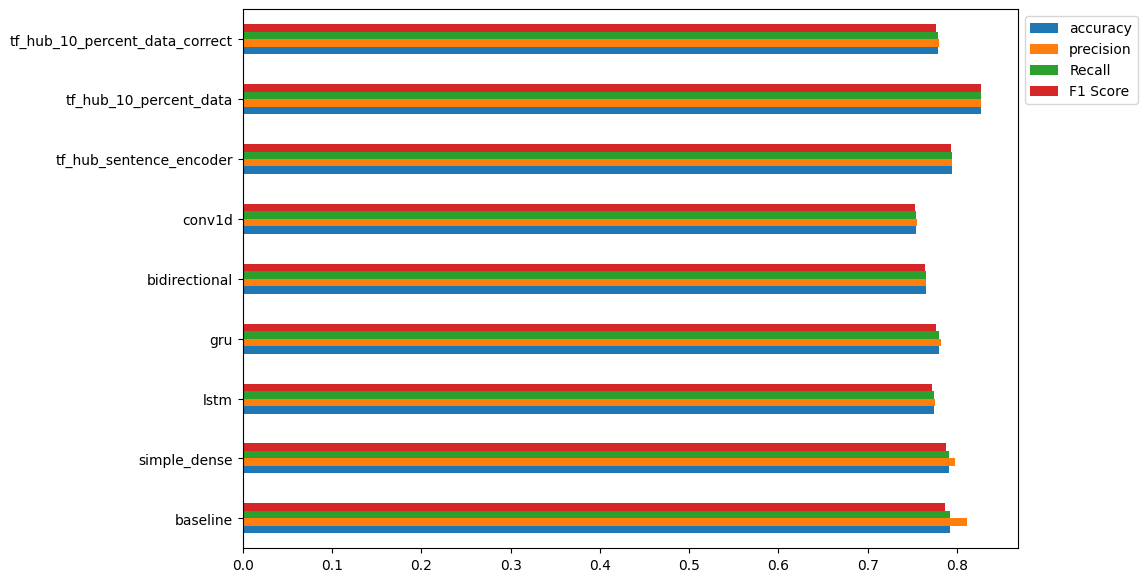

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind='barh', figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

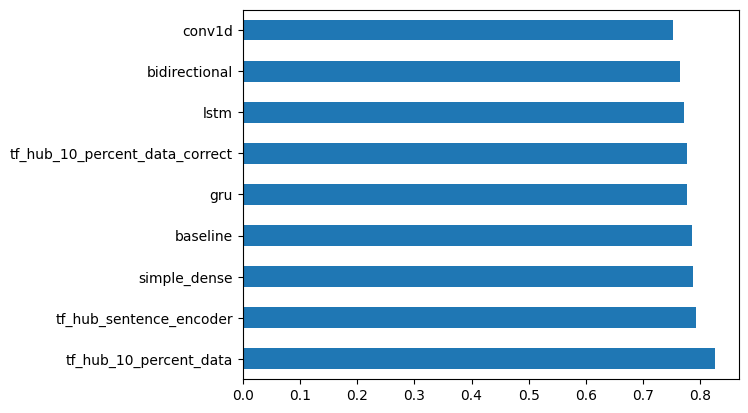

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values('F1 Score', ascending=False)['F1 Score'].plot(kind='barh')

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using tensorboard.dev

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (plus all of our other models)
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./model_logs/\
  --name "NLP Modelling Experiments" \
  --description "comparing multiple different types of model architechtures on the Kaggle dataset" \
  --one_shot # Exit the uploader once uploading is finished

2023-06-12 14:36:53.503870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VYB-VVJ-PZL



New experiment created. View your TensorBoard at: https://tensorboard.dev/experi

In [ ]:
!tensorboard dev list

2023-06-12 14:44:05.788421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/kVIrlcBVQKaTn7PpRogeRg/
	Name                 NLP Modelling Experiments
	Description          comparing multiple different types of model architechtures on the Kaggle dataset
	Id                   kVIrlcBVQKaTn7PpRogeRg
	Created              2023-06-12 14:37:32 (6 minutes ago)
	Updated              2023-06-12 14:37:47 (6 minutes ago)
	Runs                 20
	Tags                 5
	Scalars              300
	Tensor bytes         0
	Binary object bytes  6383268
https://tensorboard.dev/experiment/89WjZ42dRJyjCvBINnL25w/
	Name                 Transfer Learning Experiements with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning 
	Id                   89WjZ42dRJyjCvBINnL25w
	Created              2022-07-16 06:26:21
	Updated              2022-07-16 

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The SavedModel format (the is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 16ms/step - loss: 0.4945 - accuracy: 0.7940


[0.4944903254508972, 0.7939632534980774]

### Now let's save to the savemodel format

In [ ]:
# Save TF Hub sentence encoder model to savemodel format (default)
model_6.save('model_6_SavedModel_format')

In [ ]:
# Load in a model from a savedmodel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 11ms/step - loss: 0.4945 - accuracy: 0.7940


[0.4944903254508972, 0.7939632534980774]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples, which one is it getting *most* wrong (those will predict a prediction probability closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa

In [ ]:
# Download a pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-06-12 15:55:21--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   159MB/s    in 6.3s    

2023-06-12 15:55:28 (145 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variable

In [ ]:
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 17ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create a dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print("-----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, Pred: 1.0, Prob: 0.835454523563385
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-----

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!


In [ ]:
# Check the false positives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print("-----\n")

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text:
@DavidVonderhaar At least you were sincere ??

-----

Target: 1, Pred: 0.0, Prob: 0.05507584661245346
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

Target: 1, Pred: 0.0, Prob: 0.054596997797489166
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, Pred: 0.0, Prob: 0.04963729530572891
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

Target: 1, Pred: 0.0, Prob: 0.04391849786043167
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

Target: 1, Pred: 0.0, Pro

## Making predictions on the test dataset

In [ ]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)}, Prob: {pred_prob}')
  print(f'Text:\n{test_sample}\n')
  print('-----\n')

1/1 [==============================] - 0s 39ms/step
Pred: 1, Prob: 0.9726604223251343
Text:
The same UN who stood&amp;watched the Serbs massacre thousands of muslims in Yougslavia ?don't need any lessons off them https://t.co/Ubf3CFzfEX

-----

1/1 [==============================] - 0s 42ms/step
Pred: 1, Prob: 0.9042808413505554
Text:
It doesn't get any closer. Heavy rain just barely missed @TontitownGrape festival but lightning TOO CLOSE #TGF2015 http://t.co/d9PQIXaTX6

-----

1/1 [==============================] - 0s 43ms/step
Pred: 0, Prob: 0.03134089335799217
Text:
seeing more blood and surgery than a regular GP behind a desk and they say dentists aren't  real doctors .... Ok

-----

1/1 [==============================] - 0s 44ms/step
Pred: 0, Prob: 0.1720014214515686
Text:
Detonation fashionable mountaineering electronic watch water-resistant couples leisure tabÛ_ http://t.co/RqOvPljpse http://t.co/UhKwVSoWSt

-----

1/1 [==============================] - 0s 42ms/step
Pred: 1, Pr

## The Speed/Score Tradeoff

In [ ]:
# Lets make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  '''
  Times how long a model takes to make predictions on samples
  '''
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time/ len(samples)
  return total_time, time_per_pred


In [ ]:
# Calc TF HUB sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 16ms/step


(0.7448892479997085, 0.0009775449448815071)

In [ ]:
# Calc our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                            samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.034834219999993365, 4.571419947505691e-05)

In [ ]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'Recall': 0.8162729658792651,
 'F1 Score': 0.8148082644367335}

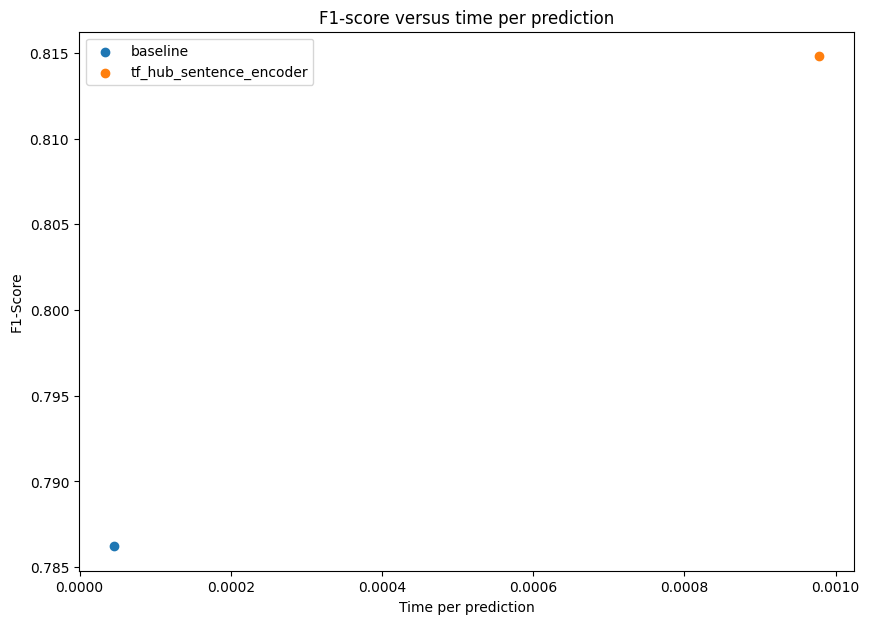

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["F1 Score"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["F1 Score"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");